## Simulate impermanent loss for Uniswap (V2)

Core reference is this article:

- https://medium.com/gammaswap-labs/expected-impermanent-loss-in-uniswap-v2-v3-7fb81033bd81

In [1]:
from dateutil.relativedelta import relativedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import quantstats as qs
import warnings
FIGSIZE = (8,3)
SEED = 123
START_DATE = pd.to_datetime("2000-01-01")
np.set_printoptions(suppress=True)

def compute_performance_stats(prices):
    """
    Compute performance statistics for prices, converting to returns.

    Parameters
    ----------
    prices (np.array): array of size (N,)
    """
    daily_returns = pd.DataFrame(prices, columns=['price']).pct_change().dropna()
    # add date range
    dummy_date_range = [None] * len(daily_returns)
    dummy_date_range[0] = START_DATE
    for i in range(1, len(dummy_date_range)):
        dummy_date_range[i] = (dummy_date_range[i-1] + relativedelta(days=1))
    daily_returns.index = pd.DatetimeIndex(dummy_date_range)
    daily_returns = daily_returns.iloc[:,0] # series
    _ = daily_returns.plot(grid=True, figsize=(8, 3))
    plt.title("Time series of returns")
    plt.ylabel("(r*100)%")
    plt.show()
    print()
    print("""

==============================
PERFORMANCE STATISTICS

    """)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        print(qs.reports.metrics(daily_returns))


### Quick code references

Stochastic processes: https://stochastic.readthedocs.io/en/latest/continuous.html

#### Example: impermanent loss function

Two assets $x$ and $y$, constant AMM so that $xy=L^2$, and price of $y$ in terms of $x$ is given by $p = \frac{x}{y}$. ($x$ is the numeraire.)

$$
\textbf{IL}(k) = \frac{2\sqrt{k}}{1 + k} - 1
$$

for a price movement from $p \to kp$, $k>0$.

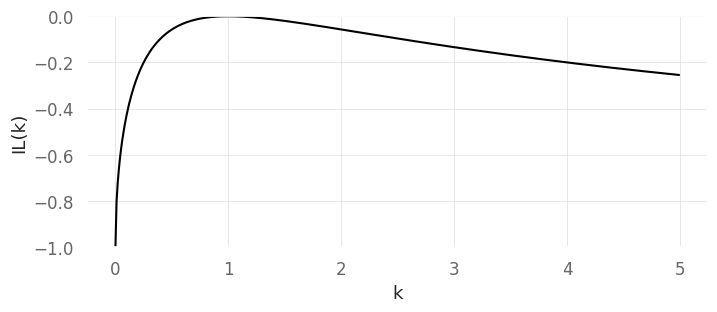

In [2]:
def il(k):
    return(
        (2 * np.sqrt(k)) / (1 + k) - 1
    )

x = np.arange(0, 5, 0.01) # this is "k"
y = [il(xi) for xi in x]
plt.figure(figsize=FIGSIZE)
plt.plot(x, y, color="black")
plt.xlabel("k")
plt.ylabel("IL(k)")
plt.ylim(-1, 0)
plt.grid(True)

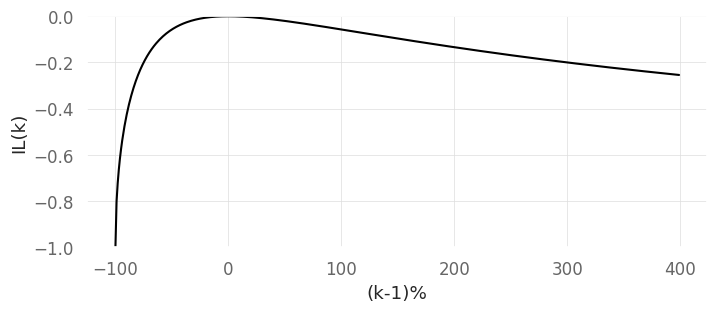

In [3]:
"""
since (k = p' / p) for p --> p',
renormalize to k-1 to get a real %.
"""

x = np.arange(0, 5, 0.01) # this is "k"
y = [il(xi) for xi in x]
plt.figure(figsize=FIGSIZE)
plt.plot([
    (xi-1)*100 for xi in x
], y, color="black")
plt.xlabel("(k-1)%")
plt.ylabel("IL(k)")
# plt.xlim(-100, 100)
plt.ylim(-1, 0)
plt.grid(True)

In [4]:
# as expected

#### Example: Brownian motion

$$
dS_t = \mu dt + \sigma dB_t
$$

[ 0.         -0.02055619 -0.01027801  0.00711905  0.03905411  0.02780779
 -0.01867996 -0.05646281 -0.03664744 -0.04899315]


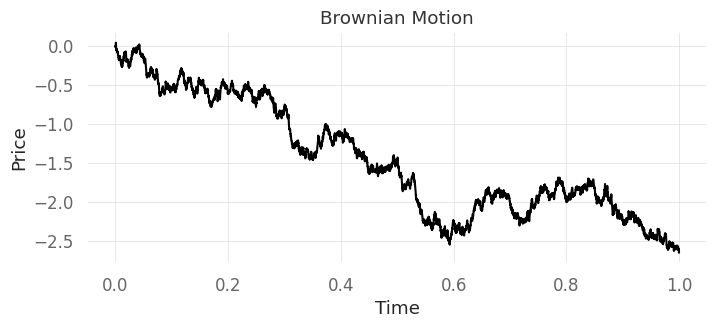

In [5]:
from stochastic.processes.continuous import BrownianMotion
from stochastic import random
def set_stochastic_seed(seed=1331):
    random.seed(1331)
    random.use_randomstate()

# Parameters
mu = 10 / 252                   # daily return (annualized / 252)
sigma = 20 / np.sqrt(252)       # daily vol (annualized / sqrt(252))
t = 1                          # time period
n = 252*20                     # number of time steps

# Simulate GBM
gbm = BrownianMotion(drift=mu, scale=sigma, t=t)
gbm_samples = gbm.sample(n) # inital value
print(gbm_samples[:10]) # starts at 1

# Plot
plt.figure(figsize=(8,3))
plt.plot(np.linspace(0, t, n+1), gbm_samples, color="black")
plt.title('Brownian Motion')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.show()

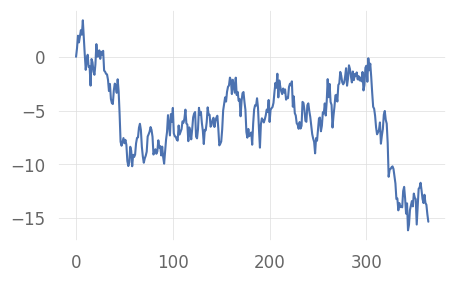

In [6]:
# example of Brownian with N(0,1) increments
plt.figure(figsize=(5,3))
plt.plot(BrownianMotion(drift=0, scale=1, t=365).sample(n=365-1)) # [n] steps over interval [0, t]

### Example: drift-diffusion process

Deterministic drift, stochastic diffusion with Brownian.

$$
\begin{align}
    dS_t &= \mu dt + \sigma dB_t & B_t \sim N(0, 1)
\end{align}
$$

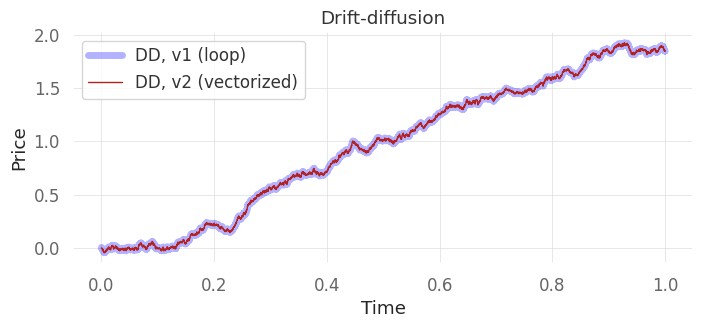

In [7]:
from stochastic.processes.continuous import GeometricBrownianMotion
from stochastic import random
set_stochastic_seed(1441)

# Parameters
mu = 0.10/252
sigma = 0.25
t = 1                          # time period: [1, T], represent the historical time interval
n = 252*20                     # number of time steps
time_grid = np.linspace(0, t, n)

# Simulate Brownian
bm = BrownianMotion(drift=mu, scale=sigma, t=t)
bm_samples = gbm.sample(n)

# Construct drift-diffusion, version 1
St = np.zeros(shape=(n,)); St[0] = 0
for t in range(1, n):
    St[t] = mu * t + sigma * bm_samples[t]

# Construct drift-diffusion, version 2
St_vec = mu * (time_grid * t) + sigma * bm_samples[1:]
St_vec[0] = 0

# # Plot
plt.figure(figsize=(8,3))
plt.plot(time_grid, St, color="blue", label="DD, v1 (loop)", alpha=0.3, linewidth=5)
plt.plot(time_grid, St_vec, color="firebrick", label="DD, v2 (vectorized)", linewidth=1)
plt.title('Drift-diffusion')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.show()

#### Example: Geometric Brownian Motion

$$
d S_t = \mu S_t dt + \sigma S_t dB_t
$$

Used in Black-Scholes to model stock prices. Note this takes an initial value $S_0 \neq 0$ for the geometric motion. Remember $\mu, \sigma$ should converted to represent daily change in stock prices.

[1.         0.99909177 0.99693791 0.99114734 0.99678276 0.98840905
 0.98940559 0.99876779 1.00727577 1.01626559]


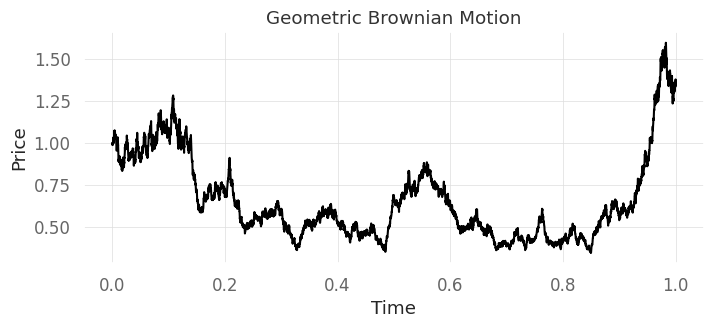

In [8]:
from stochastic.processes.continuous import GeometricBrownianMotion
from stochastic import random
set_stochastic_seed(1441)

# Parameters
mu = 10 / 252                  # daily return (annualized: 10%)
sigma = 20 / np.sqrt(252)      # daily vol (annualized: 20%)
t = 1                          # time period: [1, T], represent the historical time interval
n = 252*20                     # number of time steps

# Simulate GBM
gbm = GeometricBrownianMotion(drift=mu, volatility=sigma, t=t)
gbm_samples = gbm.sample(n, initial=1) # inital value
print(gbm_samples[:10]) # starts at 1

# Plot
plt.figure(figsize=(8,3))
plt.plot(np.linspace(0, t, n+1), gbm_samples, color="black")
plt.title('Geometric Brownian Motion')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.show()

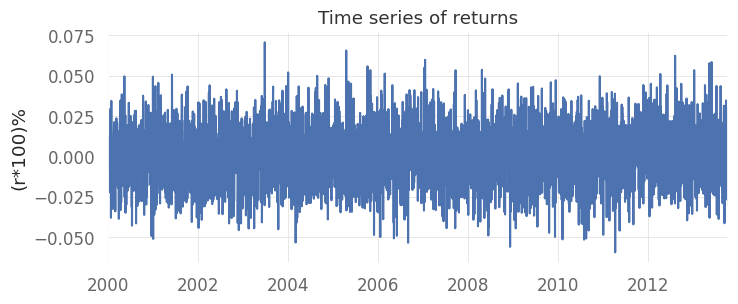




PERFORMANCE STATISTICS

    
                    Strategy
------------------  ----------
Start Period        2000-01-01
End Period          2013-10-18
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   33.81%
CAGR﹪              1.47%

Sharpe              0.19
Prob. Sharpe Ratio  80.33%
Sortino             0.27
Sortino/√2          0.19
Omega               1.03

Max Drawdown        -73.09%
Longest DD Days     4305

Gain/Pain Ratio     0.03
Gain/Pain (1M)      0.19

Payoff Ratio        1.02
Profit Factor       1.03
Common Sense Ratio  1.04
CPC Index           0.53
Tail Ratio          1.01
Outlier Win Ratio   3.04
Outlier Loss Ratio  2.88

MTD                 2.5%
3M                  -12.73%
6M                  9.06%
YTD                 66.12%
1Y                  96.04%
3Y (ann.)           34.16%
5Y (ann.)           12.92%
10Y (ann.)          6.15%
All-time (ann.)     1.47%

Avg. Drawdown       -7.86%
Avg. Drawdown Days  185
Recovery Factor     1.44
Ulcer Index    

In [9]:
compute_performance_stats(gbm_samples)

### Simulate impermanent loss (Uniswap V2) in a liquidity pool

This is based on the references:

- https://medium.com/gammaswap-labs/total-returns-and-impermanent-loss-in-uniswap-v2-9f3d5b6ebc89
- https://medium.com/gammaswap-labs/expected-impermanent-loss-in-uniswap-v2-v3-7fb81033bd81

#### Setup

Times $t = 1 \dots T$.

In [10]:
DAYS_IN_YEAR = 365
T = DAYS_IN_YEAR * 10 # because defi is 24/7
T_grid = range(T)

#### Liquidity stake: revenue growth due to trading fees

Say I put in an amount $C$. Over time I accrue trading fees and these compound continuously, so that my value grows as:

$$
\begin{align}
    V_t &= V_0 e^{at} & \text{value over time} \\
    R_t &= e^{at} - 1 & \text{returns (\%) over time}
\end{align}
$$

for some $a > 0$ and initial $V_0>0$. Note that this corresponds to the differential equations:

$$
\begin{align}
    dV_t &= a V_t dt \\
    dR_t &= a (R_t + 1) dt
\end{align}
$$

This is obtained easily by taking the derivative and substituting. To approximate this recursively we can for instance write, for some small time step $\Delta>0$:

$$
\begin{align}
    \frac{dV_{t+\Delta}}{dt} &\approx \frac{V_{t+\Delta} - V_{t}}{\Delta} \\
    \therefore \frac{V_{t+\Delta} - V_{t}}{\Delta} &\approx a V_t \\
    \therefore V_{t+\Delta} &\approx V_t + \Delta a V_t
\end{align}
$$

If we let $\Delta=1$ this corresponds to our time grid.

*Solving for a plausible value of $\alpha$*. Aim for say 10% annualized return:
$$
\begin{align}
(1+\alpha)^{252} = 1+0.10 &\Rightarrow \alpha=(1+0.10)^{-252} - 1 \approx 0.000379
\end{align}
$$

Text(0.5, 1.0, 'Valuation of liquidity stake over time')

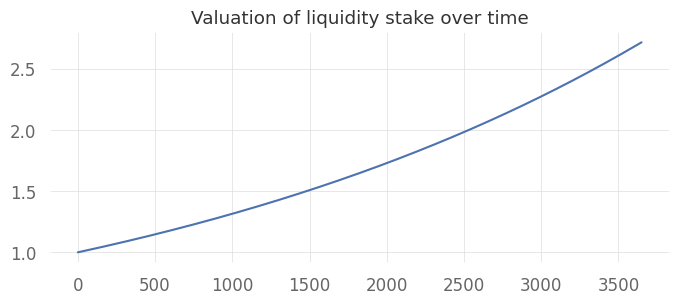

In [11]:
alpha = 0.10 / DAYS_IN_YEAR # annualized return: 10%
V_t = np.zeros(shape=(T,))
V_t[0] = 1
for t in range(1, T): # indices 1, ..., T-1
    V_t[t] = (1+alpha) * V_t[t-1]

plt.figure(figsize=FIGSIZE)
plt.plot(T_grid, V_t)
plt.title("Valuation of liquidity stake over time")

#### Liquidity stake: nominal variation due to relative price changes

For the value of the pool, we have:

$$
\begin{align}
    V &= xp + y &\text{value of the pool} \\
    p &= \frac{y}{x} &\text{price of y in terms of x, with x numeraire} \\
    xy &= L^2 &\text{conservation law}
\end{align}
$$

Some algebra and this yields, in terms of $L$ and $p$:

$$
\begin{align}
    y &= L \sqrt{p} \\ 
    x &= \frac{L}{\sqrt{p}}
\end{align}
$$

Substituting, we can write:

$$
\begin{align}
    V &= xp + y = \frac{L}{\sqrt{p}} p + L \sqrt{p} = 2L\sqrt{p} & \text{value as a function of initial liquidity stake, and changes in price}
\end{align}
$$

**This gives the value of the pool purely in terms of the initial liquidity and the relative price (aka ratio) between $x$ and $y$.**

Hence for future prices relative to the initial $p_0$, we can write:

$$
\begin{align}
    V_0 &= 2L\sqrt{p_0}=2L &\text{initial stake, with an initial equal price } p_0=1 \\
    V_1 &= 2L\sqrt{p_1} &\text{later stake, with a new price } p_1 \\
\end{align}
$$

Note that $p$ is a relative price and so represents a ratio, hence if we want % price we should use $(p-1)$.

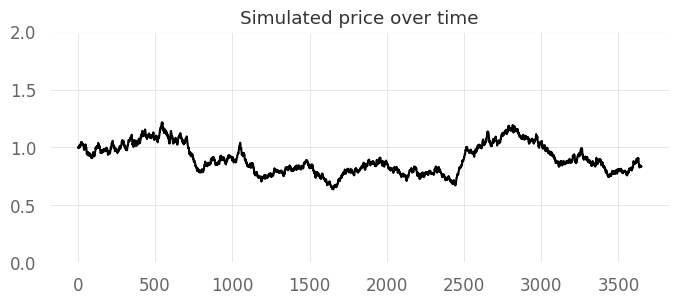

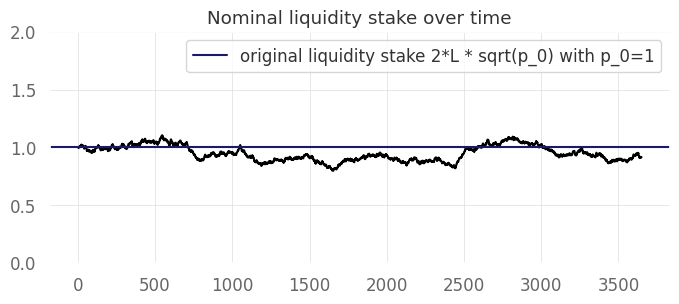

In [12]:
set_stochastic_seed()

L = 0.5
p0 = 1
V_t = np.zeros(shape=(T,))
V_t[0] = 2 * L * np.sqrt(p0) # V_0: initial stake = 1, and with p0=1

# Simulate price movement.
# Prices here are modeled via GBM where the drift = expected daily return
# and the vol = expected daily standard deviation. As you will see below,
# this will yield some movements around 1 which represents the movement of 
# prices accurately (ratio of reserves) for our simulation purposes.
# - annualized return: 10%
mu = 0.10 / DAYS_IN_YEAR
# - annualized vol: 20%
sigma = 0.20 / np.sqrt(DAYS_IN_YEAR)
# - will generate "n" equally spaced intervals on [1, t]
#   these can be default parameters for my use case.
[t, n] = [T, T-1] # T time periods
gbm = GeometricBrownianMotion(drift=mu, volatility=sigma, t=t)
p_t = gbm.sample(n, initial=p0)
plt.figure(figsize=FIGSIZE)
plt.ylim(0, (2*L)*2)
plt.plot(T_grid, p_t, color="black")
plt.title("Simulated price over time")
plt.show()

# Lastly, plug this into the nominal variation formulae to see the changes.
# Since we have started with V_0 (the initial liquidity stake) we will want
# to see how this changes over time.
for t in range(1, T):
    pi = p_t[t]
    V_t[t] = 2 * L * np.sqrt(pi)
plt.figure(figsize=FIGSIZE)
plt.plot(T_grid, V_t, color="black")
plt.ylim(0, (2*L)*2)
plt.title("Nominal liquidity stake over time")
plt.axhline(V_t[0], color="midnightblue", label="original liquidity stake 2*L * sqrt(p_0) with p_0=1")
plt.legend()
plt.show()

In [13]:
# as we can see, the liquidity stake's nominal value changes wrt. square root of the price

#### Liquidity stake: total nominal growth due to (revenue growth + price changes)

Combining the two, we can see that the nominal growth of the liquidity stake, due to a steady increase in trading fees and nominal price variation, is given by:

$$
\begin{align}
    V_t &= 2L \sqrt{p_t} e^{at} &\text{value, revenue growth + price changes} \\
    R_t &= \sqrt{p_t} e^{at} - 1 &\text{returns, revenue growth + price change}
\end{align}
$$

where $p_t$ is relative to the original $p_0=1$, and the latter is found via a simple percentage difference between the values.

Here, we will plot the three breakdowns:
$$
\begin{align}
    V_t &= 2L \sqrt{p_t} e^{at} &\text{value, revenue growth + price changes} \\
    V_{t}^{prv} &= 2L \sqrt{p_t} &\text{value, price changes} \\
    V_{t}^{rev} &= 2L e^{\alpha t} &\text{value, revenue growth} \\
        &\approx (1+\alpha) V_{t-1}^{rev} &\text{(equivalent SDE form)}
\end{align}
$$

where the initial liquidity is $2L$.

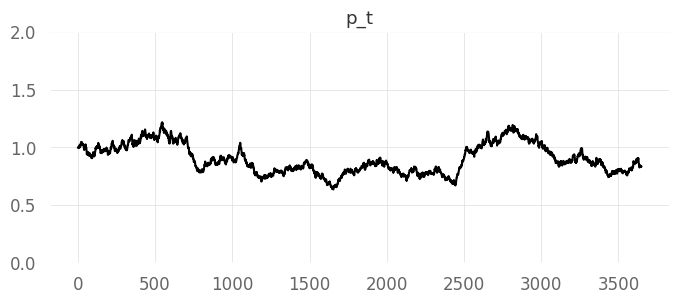

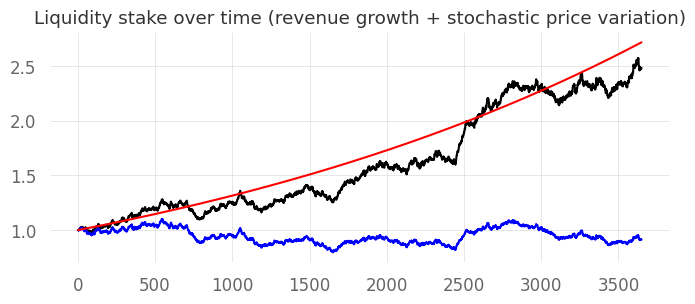

In [14]:
set_stochastic_seed()

# revenue growth parameters
alpha = 0.10 / DAYS_IN_YEAR # annualized return: 10%

# price change parameters
L = 0.5 # initial stake: 2*L
p0 = 1

# Simulate price movement.
# Prices here are modeled via GBM where the drift = expected daily return
# and the vol = expected daily standard deviation. As you will see below,
# this will yield some movements around 1 which represents the movement of 
# prices accurately (ratio of reserves) for our simulation purposes.
# - annualized return: 10%
mu = 0.10 / DAYS_IN_YEAR
# - annualized vol: 20%
sigma = 0.20 / np.sqrt(DAYS_IN_YEAR)
# - will generate "n" equally spaced intervals on [1, t]
#   these can be default parameters for my use case.
[t, n] = [T, T-1] # T time periods
gbm = GeometricBrownianMotion(drift=mu, volatility=sigma, t=t)
p_t = gbm.sample(n, initial=p0)
plt.figure(figsize=FIGSIZE)
plt.ylim(0, (2*L)*2)
plt.plot(T_grid, p_t, color="black")
plt.title("p_t")
plt.show()

# Lastly, plug this into the nominal variation formulae to see the changes.
# Since we have started with V_0 (the initial liquidity stake) we will want
# to see how this changes over time.

# - revenue growth + price variation
V_t = np.zeros(shape=(T,)); V_t[0] = 2 * L * np.sqrt(p0)
V_t_rev = np.copy(V_t)
V_t_prv = np.copy(V_t)
for t in range(1, T):
    pi = p_t[t]
    V_t[t] = 2 * L * np.sqrt(pi) * np.exp(alpha * t)
    V_t_prv[t] = 2 * L * np.sqrt(pi)
    V_t_rev[t] = (1+alpha)*V_t_rev[t-1] # recursive version as above (differential equation)
    # V_t_rev[t] = 2 * L * np.exp(alpha*t) # same result: non-recursive
plt.figure(figsize=FIGSIZE)
plt.plot(T_grid, V_t, color="black", label="V_t (rev+prv)")
plt.plot(T_grid, V_t_prv, color="blue", label="V_t_prv")
plt.plot(T_grid, V_t_rev, color="red", label="V_t_rev")
plt.title("Liquidity stake over time (revenue growth + stochastic price variation)")
plt.show()

#### Impermanent loss

Consider a price change $p \to p'=(kp), k>0$ with an initial price $p$. (This could be $p_0$).

If we have done nothing with our pool yet face this new price change, we simply plug this into our formula for the pool value with price change. This is the **baseline staked value against the price change.**

$$
\begin{align}
    V_{pool} &= 2 L \sqrt{p'} & \text{value with price change formula} \\
        &= 2 L \sqrt{k p}
\end{align}
$$

which is like our liquidity stake w/relative price changes as before.

However, if we dissolve our assets in the pool and calculate the new total value with the price, we obtain a different expression. This is the **value if we held our assets outside the pool.**

$$
\begin{align}
    V_{held} &= x p' + y = \frac{L}{\sqrt{p}} p' + L \sqrt{p'} &\text{use expressions above} \\
        &= \frac{L}{\sqrt{p}} k p + L \sqrt{k p} \\
        &= L \sqrt{p} (1 + k)
\end{align}
$$

Comparing these we obtain the **impermanent loss (IL)**:

$$
\begin{align}
    \textbf{IL}(p') &= \frac{V_{pool}}{V_{held}} - 1 = \frac{2 \sqrt{k}}{(1+k)} - 1
\end{align}
$$

In this code block we will simulate $V_{pool}, V_{held}, IL$. Note that $V_{pool}$ is done in the same way as the above "staked value against price changes" as above.

As a bonus we also $V_{poolrev}$ which is $V_{pool}$ but also includes the revenue from trading fees.

$$
\begin{align}
    V_{poolrev} &= 2L \sqrt{k p} e^{\alpha t}
\end{align}
$$

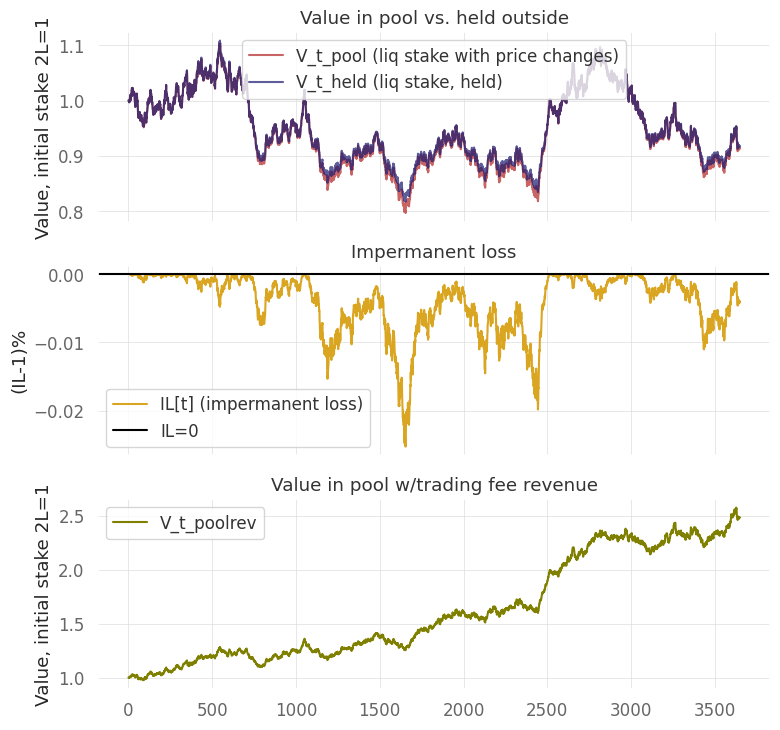

In [15]:
### Parameters as before
set_stochastic_seed()

# revenue growth parameters
alpha = 0.10 / DAYS_IN_YEAR # annualized return: 10%

# price change parameters
L = 0.5 # initial stake: 2*L
p0 = 1

# Simulate price movement.
# Prices here are modeled via GBM where the drift = expected daily return
# and the vol = expected daily standard deviation. As you will see below,
# this will yield some movements around 1 which represents the movement of 
# prices accurately (ratio of reserves) for our simulation purposes.
# - annualized return: 10%
mu = 0.10 / DAYS_IN_YEAR
# - annualized vol: 20%
sigma = 0.20 / np.sqrt(DAYS_IN_YEAR)
# - will generate "n" equally spaced intervals on [1, t]
#   these can be default parameters for my use case.
[t, n] = [T, T-1] # T time periods
gbm = GeometricBrownianMotion(drift=mu, volatility=sigma, t=t)
p_t = gbm.sample(n, initial=p0)
# plt.figure(figsize=FIGSIZE)
# plt.ylim(0, (2*L)*2)
# plt.plot(T_grid, p_t, color="black")
# plt.title("p_t")
# plt.show()

### Now do V_pool, V_held, IL.

V_t_pool = np.zeros(shape=(T,)); V_t_pool[0] = 2 * L * np.sqrt(p0)
V_t_held = np.copy(V_t_pool)
IL_t = np.zeros(shape=(T,1)); IL_t[0] = 0 # because V_pool/V_held-1 = 0
V_t_poolrev = np.copy(V_t_pool)
for t in range(1, T):
    pi = p_t[t]
    k = pi / p0 # technically just pi because p0=1
    V_t_pool[t] = 2 * L * np.sqrt(pi)
    V_t_held[t] = (
        L * np.sqrt(p0) * (1+k)
    )
    IL_t[t] = V_t_pool[t] / V_t_held[t] - 1
    V_t_poolrev[t] = V_t_pool[t] * np.exp(alpha * t)

f, ax = plt.subplots(figsize=(FIGSIZE[0], FIGSIZE[1]*2.5), nrows=3, sharex=True)

plt.axes(ax[0])
plt.plot(T_grid, V_t_pool, color="firebrick", label="V_t_pool (liq stake with price changes)", alpha=0.7)
plt.plot(T_grid, V_t_held, color="midnightblue", label="V_t_held (liq stake, held)", alpha=0.7)
plt.title("Value in pool vs. held outside")
plt.ylabel("Value, initial stake 2L=1")
plt.legend()

plt.axes(ax[1])
plt.plot(T_grid, IL_t, color="goldenrod", label="IL[t] (impermanent loss)")
plt.axhline(0, color="black", label="IL=0")
plt.title("Impermanent loss")
plt.ylabel("(IL-1)%")
plt.legend()

plt.axes(ax[2])
plt.plot(T_grid, V_t_poolrev, color="olive", label="V_t_poolrev")
plt.title("Value in pool w/trading fee revenue")
plt.ylabel("Value, initial stake 2L=1")
plt.legend()

plt.tight_layout()

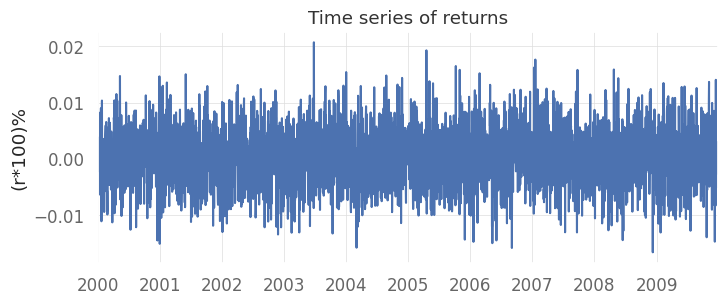




PERFORMANCE STATISTICS

    
                    Strategy
------------------  ----------
Start Period        2000-01-01
End Period          2009-12-27
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   148.31%
CAGR﹪              6.48%

Sharpe              0.81
Prob. Sharpe Ratio  99.9%
Sortino             1.2
Sortino/√2          0.85
Omega               1.14

Max Drawdown        -14.6%
Longest DD Days     487

Gain/Pain Ratio     0.14
Gain/Pain (1M)      1.15

Payoff Ratio        1.04
Profit Factor       1.14
Common Sense Ratio  1.19
CPC Index           0.62
Tail Ratio          1.04
Outlier Win Ratio   3.01
Outlier Loss Ratio  2.87

MTD                 -1.76%
3M                  7.49%
6M                  8.79%
YTD                 5.82%
1Y                  5.9%
3Y (ann.)           5.18%
5Y (ann.)           6.95%
10Y (ann.)          6.48%
All-time (ann.)     6.48%

Avg. Drawdown       -1.75%
Avg. Drawdown Days  30
Recovery Factor     6.56
Ulcer Index         0.05

In [16]:
compute_performance_stats(V_t_poolrev)